In [1]:
%matplotlib inline
import keras.backend as K

Using TensorFlow backend.


## Tell Tensorflow to use no more GPU RAM than necessary

In [2]:
K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

## prepare files

In [3]:
import glob
from PIL import Image
import numpy as np

In [4]:
fnames = glob.glob('train/*/*.JPEG', recursive=True)
len(fnames)

19439

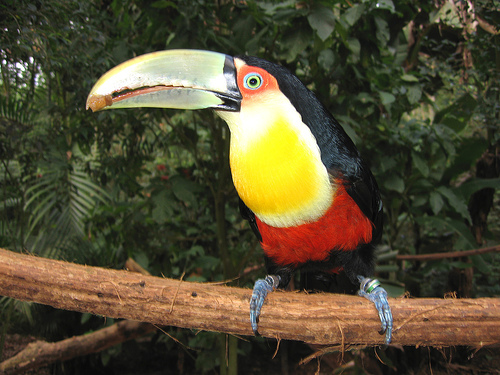

In [5]:
img = Image.open(fnames[100]); img

In [6]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [7]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [8]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape
shp

(1, 375, 500, 3)

## recreate input with vgg16 (avg pooling)

In [9]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, AveragePooling2D
from keras.applications.imagenet_utils import _obtain_input_shape

In [10]:
K.set_image_dim_ordering('tf')
input_shape = (375, 500, 3)
input_shape

(375, 500, 3)

In [11]:
img_input = Input(shape=input_shape)
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = AveragePooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

inputs = img_input
model = Model(inputs, x, name='vgg16')
model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 375, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 375, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 375, 500, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 187, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 187, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 187, 250, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 93, 125, 128)      0         
__________

In [12]:
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [13]:
from keras import metrics
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt

In [14]:
#loss = metrics.mse(layer, targ)
loss = K.mean(metrics.mse(layer, targ))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
loss, layer, targ

(<tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 23, 31, 512) dtype=float32>,
 <tf.Variable 'Variable:0' shape=(1, 23, 31, 512) dtype=float32_ref>)

In [15]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
evaluator = Evaluator(fn, shp)

In [16]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        #print(x.shape, min_val.shape)
        imsave(f'results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

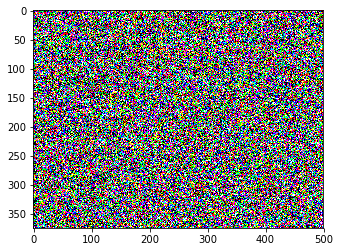

In [17]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

In [18]:
iterations=10
x = solve_image(evaluator, iterations, x)

Current loss value: 79.8310089111
Current loss value: 27.9770278931
Current loss value: 16.1220645905
Current loss value: 11.5125484467
Current loss value: 9.24797058105
Current loss value: 7.66381406784
Current loss value: 6.63432693481
Current loss value: 5.89841079712
Current loss value: 5.3270406723
Current loss value: 4.887196064


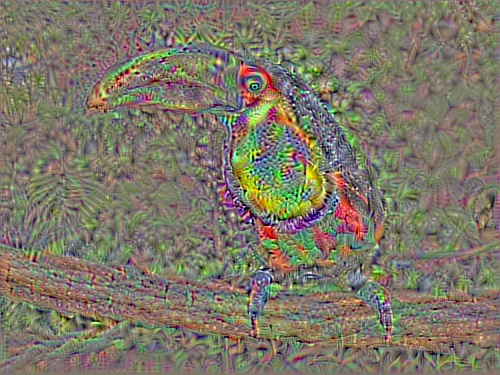

In [19]:
Image.open('results/res_at_iteration_1.png')

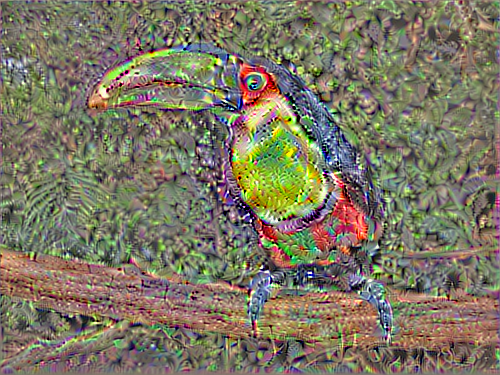

In [20]:
Image.open('results/res_at_iteration_9.png')

RuntimeError: No MovieWriters available!

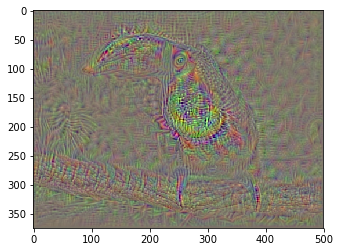

In [21]:
from IPython.display import HTML
from matplotlib import animation, rc
fig, ax = plt.subplots()
def animate(i):
    ax.imshow(Image.open(f'results/res_at_iteration_{i}.png'))
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

No MovieWriters available http://forums.fast.ai/t/runtimeerror-no-moviewriters-available/1888

## recreate style

In [22]:
def plot_arr(arr):
    plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

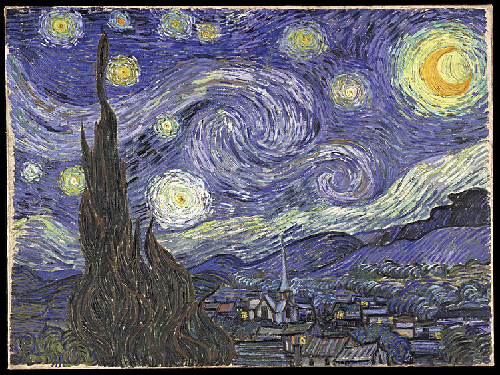

In [26]:
style = Image.open('starry_night.jpg')
style = style.resize((500, 375)); style

In [30]:
style_arr = preproc(np.expand_dims(style,0))
shp = style_arr.shape

In [31]:
outputs = {l.name: l.output for l in model.layers}
outputs

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 375, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 375, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/AvgPool:0' shape=(?, 187, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 187, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 187, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/AvgPool:0' shape=(?, 93, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 93, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 93, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 93, 125, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/AvgPool:0' shape=(?, 46, 62, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 46, 62, 512) dtype=float32>,
 'block

In [32]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1, 3)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [33]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [55]:
def style_loss(x, targ):
    #return metrics.mse(gram_matrix(x), gram_matrix(targ))
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [60]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

In [38]:
import scipy

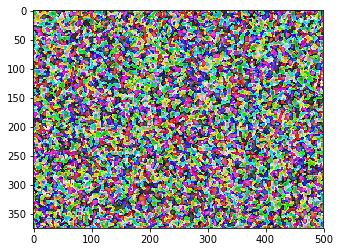

In [62]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
plt.imshow(x[0])

In [63]:
x = solve_image(evaluator, 10, x)

Current loss value: 3521.07763672
Current loss value: 340.875671387
Current loss value: 138.576660156
Current loss value: 78.7184906006
Current loss value: 56.1223564148
Current loss value: 41.595085144
Current loss value: 31.3931808472
Current loss value: 23.9600658417
Current loss value: 17.9211387634
Current loss value: 13.6190185547


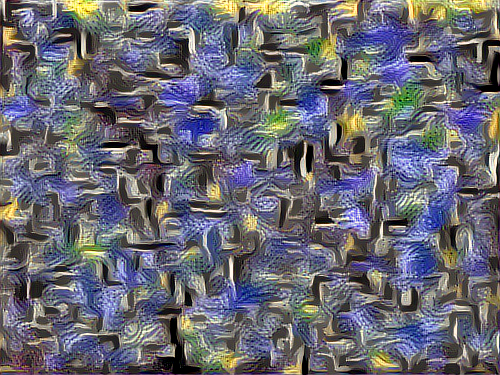

In [64]:
Image.open('results/res_at_iteration_9.png')

## transfer style

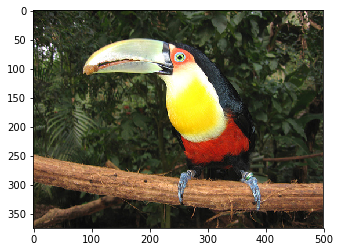

In [67]:
w, h = style.size
src = img_arr[:, :h, :w]
plot_arr(src)

In [68]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [69]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [70]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [71]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [75]:
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += K.mean(metrics.mse(content_layer, content_targ)/10)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [73]:
evaluator = Evaluator(transfer_fn, shp)

In [76]:
x = rand_img(shp)
x = solve_image(evaluator, iterations, x)

Current loss value: [[[ 67303.015625   67297.4375     67201.2734375 ...,  67320.203125
    67500.4609375  67575.75     ]
  [ 67273.1640625  67215.4296875  67146.765625  ...,  67229.828125
    67320.5390625  67465.6640625]
  [ 67207.890625   67152.0234375  67122.03125   ...,  67269.1875
    67268.7109375  67318.09375  ]
  ..., 
  [ 67283.6328125  67281.96875    67211.6875    ...,  67334.390625
    67425.0078125  67523.921875 ]
  [ 67273.859375   67197.3203125  67187.8359375 ...,  67339.3203125
    67381.28125    67399.34375  ]
  [ 67307.796875   67307.6796875  67233.546875  ...,  67345.8046875
    67405.3515625  67351.8515625]]]
Current loss value: [[[ 67303.015625   67297.4375     67201.2734375 ...,  67320.203125
    67500.4609375  67575.75     ]
  [ 67273.1640625  67215.4296875  67146.765625  ...,  67229.828125
    67320.5390625  67465.6640625]
  [ 67207.890625   67152.0234375  67122.03125   ...,  67269.1875
    67268.7109375  67318.09375  ]
  ..., 
  [ 67283.6328125  67281.96875    6

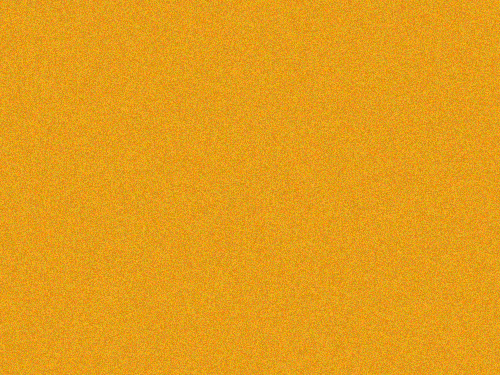

In [78]:
Image.open('results/res_at_iteration_9.png')